## Climate time series analysis
* Charge and preprocess data
* Time series clustering 
* Causal analysis

In [1]:
import pandas as pd
import numpy as np
import os
import datetime
from tensorflow.keras import layers, Model
from tslearn.clustering import TimeSeriesKMeans
from tslearn.barycenters import dtw_barycenter_averaging as dtw_avg
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline     

In [2]:
col_names = pd.read_csv('../dades/col_names.txt', header=None)
df = pd.DataFrame()

df.loc[:,'timestamp'] = pd.read_csv('../dades/data_per_pix/-0.5,-48.5.csv', header=None).loc[:,0].apply(datetime.datetime.fromtimestamp)

In [52]:
variables_names = ['Lag_RN_ERA_Ix5day_2', 'Lag_SM_GLEAM_ResPlusTrend_Sx5day_2','maxTXx_cum_T_ERA_2', 'monthly_Rx1day_P_CPCU']
variables_ind = [1486, 2109, 4225, 5007]

* Temperatura en Kelvin


In [90]:
df = np.empty((len(os.listdir('../test_data/assaig1/')),385,4))
pixels = []
i = 0



for file in os.listdir('../test_data/assaig1/'):
    df[i,:,:] = pd.read_csv(os.path.join('../test_data/assaig1/', file), header=None)
    i += 1
    pixels.append(file)
    


In [3]:
inp = layers.Input(shape=(df.shape[1], df.shape[2]))
    

encoder = layers.TimeDistributed(layers.Dense(50, activation='tanh'))(inp)
encoder = layers.TimeDistributed(layers.Dense(10, activation='tanh'))(encoder)
latent = layers.TimeDistributed(layers.Dense(1, activation='tanh'))(encoder)
decoder = layers.TimeDistributed(layers.Dense(10, activation='tanh'))(latent)
decoder = layers.TimeDistributed(layers.Dense(50, activation='tanh'))(decoder)
out = layers.TimeDistributed(layers.Dense(4))(decoder)

autoencoder = Model(inputs=inp, outputs=out)
autoencoder.compile(optimizer='adam', loss='mse')


autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 385, 4)]          0         
                                                                 
 time_distributed (TimeDistr  (None, 385, 50)          250       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 385, 10)          510       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 385, 1)           11        
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 385, 10)          20        
 tributed)                                                   

In [4]:
ind = np.random.permutation(df.shape[0])
training_idx, test_idx = ind[:120], ind[120:]
x_train, x_test = df[training_idx,:,:], df[test_idx,:,:]

In [12]:
history = autoencoder.fit(x_train, x_train, epochs = 2000, validation_data= (x_test, x_test))

Epoch 1/2000
4/4 [==============================] - 0s 44ms/step - loss: 84.3971 - val_loss: 69.4329
Epoch 2/2000
4/4 [==============================] - 0s 32ms/step - loss: 84.3214 - val_loss: 70.0293
Epoch 3/2000
4/4 [==============================] - 0s 30ms/step - loss: 84.2617 - val_loss: 72.1302
Epoch 4/2000
4/4 [==============================] - 0s 28ms/step - loss: 84.3700 - val_loss: 69.7991
Epoch 5/2000
4/4 [==============================] - 0s 28ms/step - loss: 85.4614 - val_loss: 69.4411
Epoch 6/2000
4/4 [==============================] - 0s 29ms/step - loss: 85.1652 - val_loss: 74.1891
Epoch 7/2000
4/4 [==============================] - 0s 29ms/step - loss: 84.9705 - val_loss: 70.9632
Epoch 8/2000
4/4 [==============================] - 0s 28ms/step - loss: 85.0770 - val_loss: 69.6931
Epoch 9/2000
4/4 [==============================] - 0s 28ms/step - loss: 84.3487 - val_loss: 70.9228
Epoch 10/2000
4/4 [==============================] - 0s 28ms/step - loss: 85.1131 - val_los

In [13]:
encoder = Model(inputs=inp, outputs=latent)
encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 385, 4)]          0         
                                                                 
 time_distributed (TimeDistr  (None, 385, 50)          250       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 385, 10)          510       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 385, 1)           11        
 tributed)                                                       
                                                                 
Total params: 771
Trainable params: 771
Non-trainable params: 0
_____________________________________________________________

In [97]:
data = encoder.predict(df)

6/6 [==============================] - 0s 2ms/step


In [98]:
data = data.reshape((len(os.listdir('../test_data/assaig1/')), 385))

In [99]:
data = pd.DataFrame(data, index = pixels)

In [100]:
model = TimeSeriesKMeans(n_clusters=8, metric="dtw", max_iter=10000)
model.fit(data)

TimeSeriesKMeans(max_iter=10000, metric='dtw', n_clusters=8)

In [101]:
results = pd.DataFrame()

In [102]:
results['group'] = model.predict(data)


c:\Users\Usuario\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 184 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


In [86]:
coord_x = []
coord_y = []

for i in range(len(pixels)):
    pixels[i] = pixels[i].replace('.csv', '')
    coord_x.append(float(pixels[i].split(',')[1]))
    coord_y.append(float(pixels[i].split(',')[0]))

In [34]:
results['coord_x'] = coord_x
results['coord_y'] = coord_y


In [22]:
results

,group,coord_x,coord_y
0,0,-48.5,-0.5
1,0,-49.5,-0.5
2,0,-50.5,-0.5
3,0,10.5,-0.5
4,0,11.5,-0.5
...,...,...,...
139,2,96.5,79.5
140,2,97.5,79.5
141,2,-66.5,80.5
142,2,-68.5,81.5


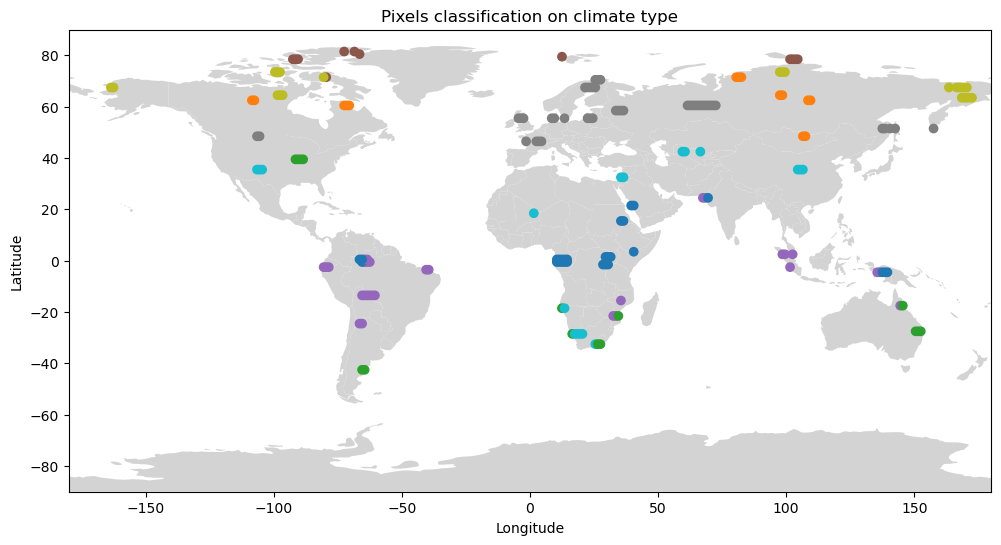

In [35]:
# From GeoPandas, our world map data
worldmap = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Creating axes and plotting world map
fig, ax = plt.subplots(figsize=(12, 6))
worldmap.plot(color="lightgrey", ax=ax)


# Plotting our pixels classification by climate type
x = tuple(results['coord_x'])
y = tuple(results['coord_y'])
z = tuple(results['group'])


plt.scatter(x, y, c=z, cmap='tab10')

# Creating axis limits and title
plt.xlim([-180, 180])
plt.ylim([-90, 90])

plt.title('Pixels classification on climate type')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [36]:
np.sum(results['group'] == 0)

28

In [109]:
mean_series = np.empty((len(set(results['group'])),385,4))

for i in set(results['group']):
    for j in range(4):
        mean_series[i,:,j] = dtw_avg(df[results['group'] == i,:,j], max_iter = 10000).reshape([385,])

Text(0.5, 1.0, 'Precipitation')

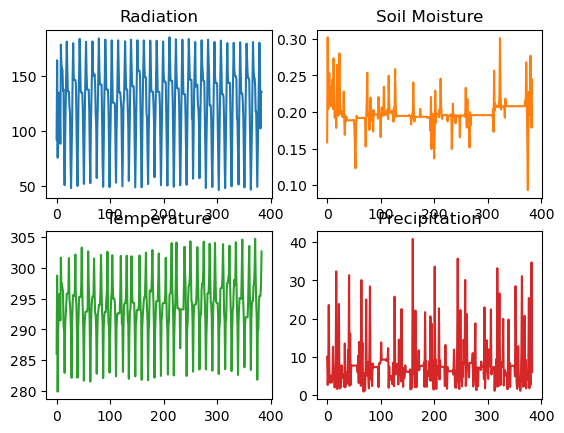

In [110]:
mean_series = mean_series[:,1:,:]

# Mitjana de cada variable per al cluster 3
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(mean_series[3,:,0])
axs[0, 0].set_title('Radiation')
axs[0, 1].plot(mean_series[3,:,1], 'tab:orange')
axs[0, 1].set_title('Soil Moisture')
axs[1, 0].plot(mean_series[3,:,2], 'tab:green')
axs[1, 0].set_title('Temperature')
axs[1, 1].plot(mean_series[3,:,3], 'tab:red')
axs[1, 1].set_title('Precipitation')

## causal analysis

In [63]:
# Imports

import numpy as np
import matplotlib
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import sklearn

import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb

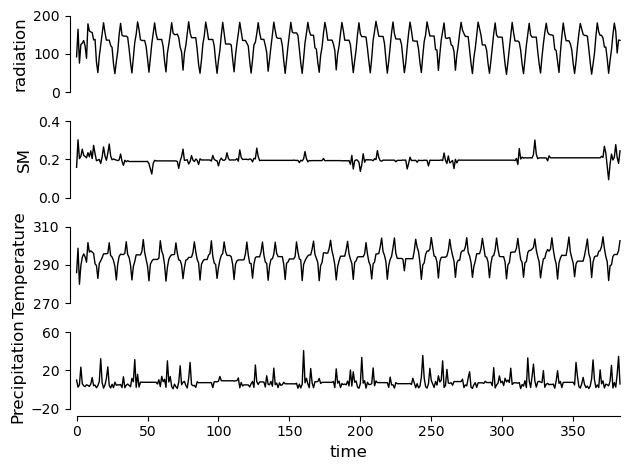

In [111]:
var_names = ['radiation', 'SM', 'Temperature', 'Precipitation']
dataframe = pp.DataFrame(mean_series[3,:,:], var_names= var_names)
                         
tp.plot_timeseries(dataframe); plt.show()

In [112]:
cmi_knn = CMIknn(significance='shuffle_test', knn=0.1, shuffle_neighbors=5, transform='ranks')
pcmci_cmi_knn = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=cmi_knn,
    verbosity=2)
results = pcmci_cmi_knn.run_pcmci(tau_max=2, pc_alpha=0.05)
pcmci_cmi_knn.print_significant_links(
        p_matrix = results['p_matrix'], 
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = cmi_knn
tau_min = 1
tau_max = 2
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1



## Variable radiation

Iterating through pc_alpha = [0.05]:

# pc_alpha = 0.05 (1/1):

Testing condition sets of dimension 0:

    Link (radiation -1) --> radiation (1/8):
    Subset 0: () gives pval = 0.00000 / val =  0.569
    No conditions of dimension 0 left.

    Link (radiation -2) --> radiation (2/8):
    Subset 0: () gives pval = 0.00000 / val =  0.330
    No conditions of dimension 0 left.

    Link (SM -1) --> radiation (3/8):
    Subset 0: () gives pval = 0.16600 / val =  0.013
    Non-significance detected.

    Link (SM -2) --> radiation (4/8):
    Subset 0: () gives pval = 0.34300 / val =  0.011
    Non-significance detected.

    Link (Temperature -1) --> radiation (5/8):
    Subset 0: () gives pval = 0.00000 / val =  0.232
    No conditions of dimension 0 left.

    Link (Temperature -2) --

In [ ]:
link_matrix = pcmci_cmi_knn.return_significant_links(pq_matrix=results['p_matrix'],
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']
tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    vmin_edges=0.,
    vmax_edges = 0.3,
    edge_ticks=0.05,
    cmap_edges='OrRd',
    vmin_nodes=0,
    vmax_nodes=.5,
    node_ticks=.1,
    cmap_nodes='OrRd',
    ); plt.show()

In [ ]:
# Plot time series graph    
tp.plot_time_series_graph(
    figsize=(6, 4),
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='MCI',
    ); plt.show()